In [10]:
# Sample size recommendations based on convergence analysis
def recommend_sample_sizes(all_results):
    """
    Provide practical recommendations for choosing sample sizes.
    """
    
    print("🎯 SAMPLE SIZE RECOMMENDATIONS")
    print("=" * 50)
    
    for name, data in all_results.items():
        print(f"\n📊 {name.upper()} Dataset:")
        
        results = data['results']
        basic_vals = data['basic_vals']
        rb_vals = data['rb_vals']
        
        true_basic_mean = np.mean(basic_vals)
        true_rb_mean = np.mean(rb_vals)
        
        # Find sample sizes for different precision targets
        precision_targets = {
            'Quick estimate (±5%)': 0.05,
            'Good estimate (±2%)': 0.02, 
            'Precise estimate (±1%)': 0.01,
            'Very precise (±0.5%)': 0.005
        }
        
        print(f"\n   Sample sizes needed for different precision levels:")
        print(f"   (Precision = 1.96 × SE / Mean, for 95% confidence)")
        print(f"   {'Target':>20} │ {'Basic Needs':>12} │ {'RB Needs':>12} │ {'RB Advantage':>15}")
        print("   " + "─" * 65)
        
        for target_name, rel_error in precision_targets.items():
            basic_needed = "N/A"
            rb_needed = "N/A" 
            advantage = "N/A"
            
            # Find minimum sample size for basic entropy
            for r in results:
                precision = (1.96 * r['basic_std_est']) / true_basic_mean
                if precision <= rel_error:
                    basic_needed = f"{r['sample_size']:,}"
                    break
            
            # Find minimum sample size for RB entropy  
            for r in results:
                precision = (1.96 * r['rb_std_est']) / true_rb_mean
                if precision <= rel_error:
                    rb_needed = f"{r['sample_size']:,}"
                    
                    # Calculate advantage if both found
                    if basic_needed != "N/A":
                        basic_n = int(basic_needed.replace(',', ''))
                        rb_n = r['sample_size']
                        if rb_n < basic_n:
                            advantage = f"{basic_n/rb_n:.1f}x smaller"
                        elif rb_n == basic_n:
                            advantage = "Same"
                        else:
                            advantage = f"{rb_n/basic_n:.1f}x larger"
                    break
            
            print(f"   {target_name:>20} │ {basic_needed:>12} │ {rb_needed:>12} │ {advantage:>15}")
        
        # Diminishing returns analysis
        print(f"\n   📈 Marginal improvement analysis:")
        print(f"   (How much does doubling sample size help?)")
        
        for i in range(1, min(4, len(results))):  # Show first few doublings
            prev_basic_se = results[i-1]['basic_std_est'] 
            curr_basic_se = results[i]['basic_std_est']
            prev_rb_se = results[i-1]['rb_std_est']
            curr_rb_se = results[i]['rb_std_est']
            
            basic_improvement = (prev_basic_se - curr_basic_se) / prev_basic_se * 100
            rb_improvement = (prev_rb_se - curr_rb_se) / prev_rb_se * 100
            
            size_from = results[i-1]['sample_size']
            size_to = results[i]['sample_size']
            
            print(f"   {size_from:,} → {size_to:,}: Basic SE improves {basic_improvement:.1f}%, RB SE improves {rb_improvement:.1f}%")
        
        print(f"   (Theoretical expectation: ~29% improvement per doubling)")

# Generate recommendations
recommend_sample_sizes(all_results)

🎯 SAMPLE SIZE RECOMMENDATIONS

📊 T1 Dataset:

   Sample sizes needed for different precision levels:
   (Precision = 1.96 × SE / Mean, for 95% confidence)
                 Target │  Basic Needs │     RB Needs │    RB Advantage
   ─────────────────────────────────────────────────────────────────
   Quick estimate (±5%) │        1,024 │          512 │    2.0x smaller
    Good estimate (±2%) │        4,096 │        4,096 │            Same
   Precise estimate (±1%) │       16,384 │       16,384 │            Same
   Very precise (±0.5%) │          N/A │          N/A │             N/A

   📈 Marginal improvement analysis:
   (How much does doubling sample size help?)
   32 → 64: Basic SE improves 31.2%, RB SE improves 32.2%
   64 → 128: Basic SE improves 30.0%, RB SE improves 29.1%
   128 → 256: Basic SE improves 31.1%, RB SE improves 31.6%
   (Theoretical expectation: ~29% improvement per doubling)


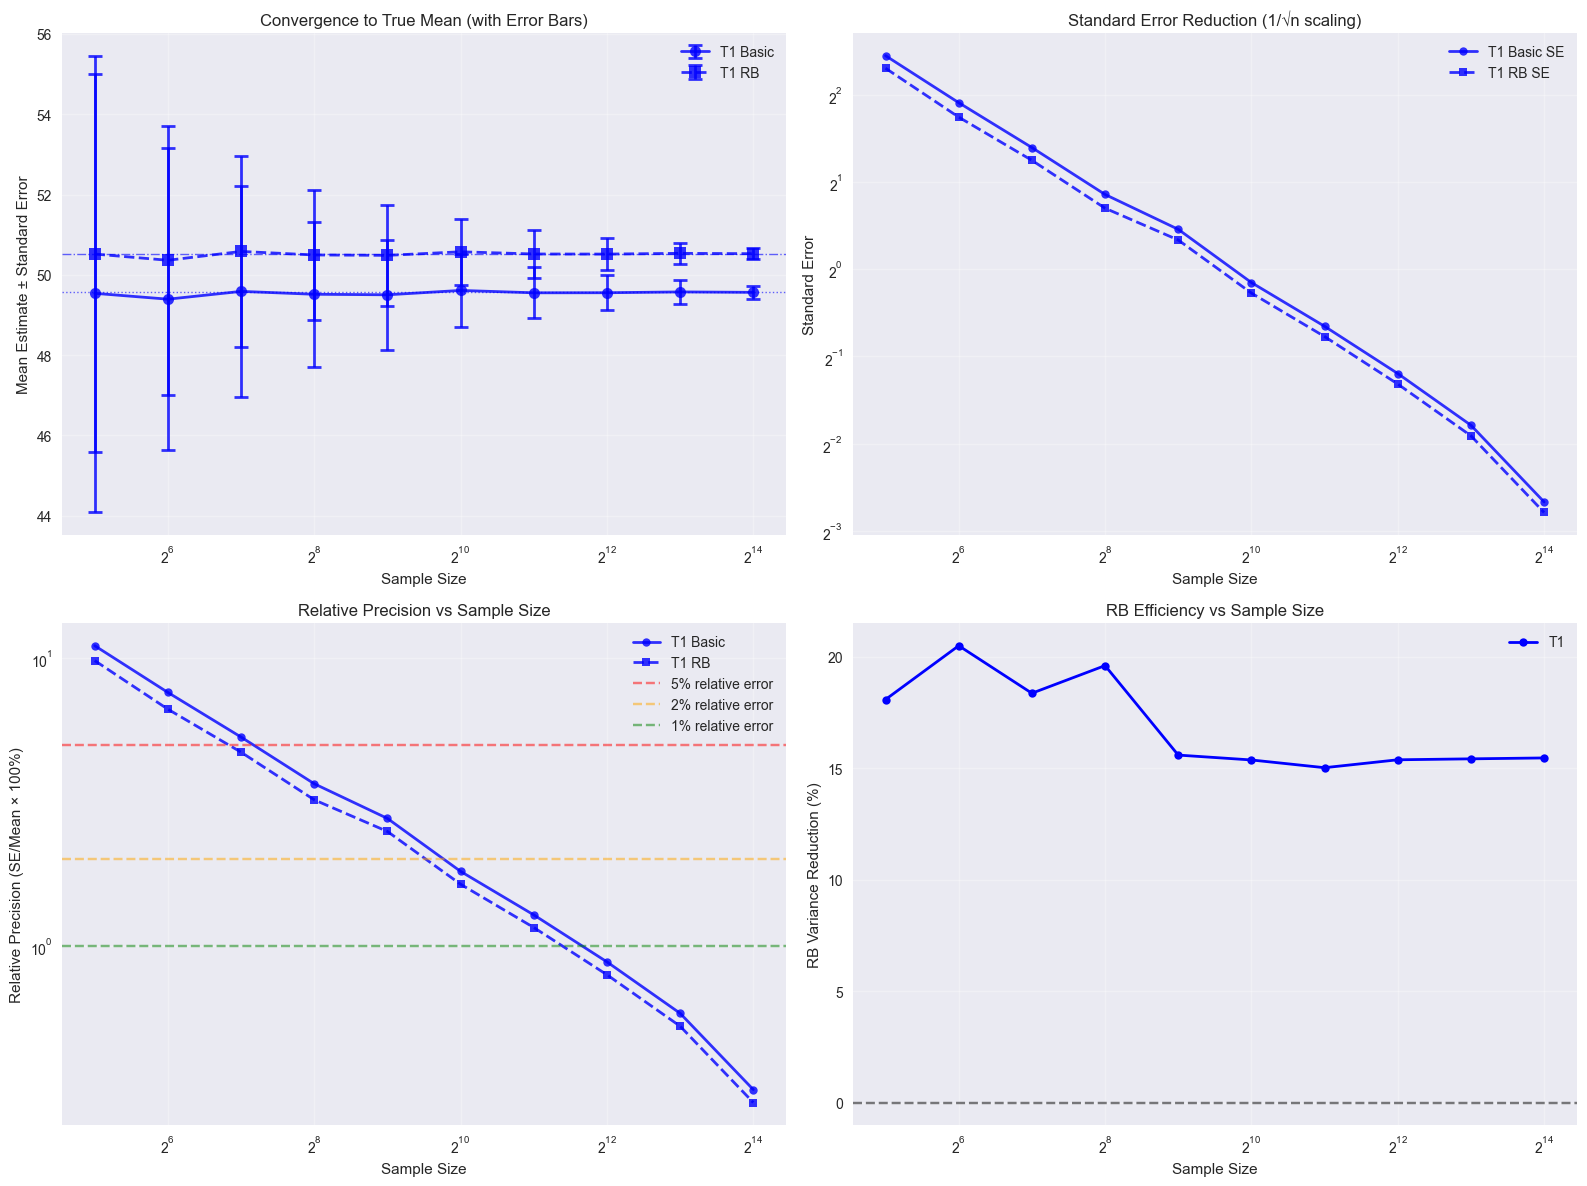

In [9]:
# Plot mean estimates with error bars to visualize convergence
def plot_convergence_with_error_bars(all_results):
    """
    Plot sample means with error bars to show convergence and determine optimal sample size.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    colors = ['blue', 'red', 'green', 'orange']
    
    for idx, (name, data) in enumerate(all_results.items()):
        results = data['results']
        basic_vals = data['basic_vals']
        rb_vals = data['rb_vals']
        
        # Extract data for plotting
        sample_sizes = [r['sample_size'] for r in results]
        basic_means = [r['basic_mean_est'] for r in results]
        basic_ses = [r['basic_std_est'] for r in results] 
        rb_means = [r['rb_mean_est'] for r in results]
        rb_ses = [r['rb_std_est'] for r in results]
        
        # True population means
        true_basic_mean = np.mean(basic_vals)
        true_rb_mean = np.mean(rb_vals)
        
        # Plot 1: Mean estimates with error bars
        ax = axes[0]
        ax.errorbar(sample_sizes, basic_means, yerr=basic_ses, 
                   fmt='o-', color=colors[idx], alpha=0.8, capsize=5, capthick=2,
                   label=f'{name} Basic', linewidth=2, markersize=8)
        ax.errorbar(sample_sizes, rb_means, yerr=rb_ses, 
                   fmt='s--', color=colors[idx], alpha=0.8, capsize=5, capthick=2,
                   label=f'{name} RB', linewidth=2, markersize=8)
        
        # True population means as horizontal lines
        ax.axhline(true_basic_mean, color=colors[idx], linestyle=':', alpha=0.6, linewidth=1)
        ax.axhline(true_rb_mean, color=colors[idx], linestyle='-.', alpha=0.6, linewidth=1)
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Mean Estimate ± Standard Error')
    ax.set_title('Convergence to True Mean (with Error Bars)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    
    # Plot 2: Standard errors only (log scale)
    ax = axes[1]
    for idx, (name, data) in enumerate(all_results.items()):
        results = data['results']
        sample_sizes = [r['sample_size'] for r in results]
        basic_ses = [r['basic_std_est'] for r in results]
        rb_ses = [r['rb_std_est'] for r in results]
        
        ax.loglog(sample_sizes, basic_ses, 'o-', color=colors[idx], alpha=0.8,
                 label=f'{name} Basic SE', linewidth=2, markersize=6, base=2)
        ax.loglog(sample_sizes, rb_ses, 's--', color=colors[idx], alpha=0.8,
                 label=f'{name} RB SE', linewidth=2, markersize=6, base=2)
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Standard Error')
    ax.set_title('Standard Error Reduction (1/√n scaling)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Relative precision (SE as % of mean)
    ax = axes[2]
    for idx, (name, data) in enumerate(all_results.items()):
        results = data['results']
        basic_vals = data['basic_vals']
        rb_vals = data['rb_vals']
        
        true_basic_mean = np.mean(basic_vals)
        true_rb_mean = np.mean(rb_vals)
        
        sample_sizes = [r['sample_size'] for r in results]
        basic_rel_precision = [r['basic_std_est'] / true_basic_mean * 100 for r in results]
        rb_rel_precision = [r['rb_std_est'] / true_rb_mean * 100 for r in results]
        
        ax.plot(sample_sizes, basic_rel_precision, 'o-', color=colors[idx], alpha=0.8,
               label=f'{name} Basic', linewidth=2, markersize=6)
        ax.plot(sample_sizes, rb_rel_precision, 's--', color=colors[idx], alpha=0.8,
               label=f'{name} RB', linewidth=2, markersize=6)
    
    # Add reference lines for common precision targets
    ax.axhline(5, color='red', linestyle='--', alpha=0.5, label='5% relative error')
    ax.axhline(2, color='orange', linestyle='--', alpha=0.5, label='2% relative error')
    ax.axhline(1, color='green', linestyle='--', alpha=0.5, label='1% relative error')
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Relative Precision (SE/Mean × 100%)')
    ax.set_title('Relative Precision vs Sample Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    
    # Plot 4: Efficiency comparison
    ax = axes[3]
    for idx, (name, data) in enumerate(all_results.items()):
        results = data['results']
        sample_sizes = [r['sample_size'] for r in results]
        
        # Calculate efficiency: how much better is RB vs Basic?
        efficiency = [(r['basic_std_est']**2 - r['rb_std_est']**2) / r['basic_std_est']**2 * 100 
                     for r in results]
        
        ax.plot(sample_sizes, efficiency, 'o-', color=colors[idx],
               label=f'{name}', linewidth=2, markersize=6)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('RB Variance Reduction (%)')
    ax.set_title('RB Efficiency vs Sample Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    
    plt.tight_layout()
    plt.show()

# Generate the plots
plot_convergence_with_error_bars(all_results)

In [15]:
# Focused analysis: Mean of means with error bars for sample size selection
def analyze_sample_means_convergence(all_results):
    """
    Print mean of means and variance for each sample size, then plot with error bars.
    """
    
    for name, data in all_results.items():
        print(f"\n{'='*60}")
        print(f"SAMPLE MEANS CONVERGENCE: {name.upper()}")
        print(f"{'='*60}")
        
        results = data['results']
        basic_vals = data['basic_vals']
        rb_vals = data['rb_vals']
        
        # True population means for reference
        true_basic_mean = np.mean(basic_vals)
        true_rb_mean = np.mean(rb_vals)
        
        print(f"True population means: Basic={true_basic_mean:.6f}, RB={true_rb_mean:.6f}")
        print()
        
        print(f"{'Sample Size':>10} │ {'Basic Mean':>12} │ {'Basic SE':>10} │ {'RB Mean':>12} │ {'RB SE':>10} │ {'Improvement':>12}")
        print("─" * 75)
        
        for r in results:
            basic_mean_est = r['basic_mean_est']
            basic_se = r['basic_std_est'] 
            rb_mean_est = r['rb_mean_est']
            rb_se = r['rb_std_est']
            
            # SE improvement: how much smaller is RB SE compared to Basic SE
            se_improvement = (basic_se - rb_se) / basic_se * 100
            
            print(f"{r['sample_size']:>10,} │ {basic_mean_est:>12.6f} │ {basic_se:>10.6f} │ {rb_mean_est:>12.6f} │ {rb_se:>10.6f} │ {se_improvement:>11.1f}%")
            
        print("─" * 75)
        print("SE = Standard Error of sample means (smaller = more reliable)")
        print("Improvement = (Basic_SE - RB_SE) / Basic_SE * 100%")

# Run the analysis
analyze_sample_means_convergence(all_results)


SAMPLE MEANS CONVERGENCE: T07
True population means: Basic=26.442694, RB=23.557274

Sample Size │   Basic Mean │   Basic SE │      RB Mean │      RB SE │  Improvement
───────────────────────────────────────────────────────────────────────────
        32 │    26.451579 │   2.578000 │    23.545719 │   2.144103 │        16.8%
        64 │    26.381140 │   1.847762 │    23.501477 │   1.512891 │        18.1%
       128 │    26.440877 │   1.305745 │    23.556840 │   1.099871 │        15.8%
       256 │    26.473591 │   0.927006 │    23.575830 │   0.755019 │        18.6%
       512 │    26.398087 │   0.659140 │    23.524367 │   0.542319 │        17.7%
     1,024 │    26.480683 │   0.435007 │    23.587984 │   0.358556 │        17.6%
     2,048 │    26.418917 │   0.310467 │    23.543409 │   0.253249 │        18.4%
     4,096 │    26.430368 │   0.226875 │    23.548223 │   0.181376 │        20.1%
     8,192 │    26.437474 │   0.139966 │    23.553204 │   0.117507 │        16.0%
    16,384 │    26

# Entropy Convergence Analysis - Updated for 32k Samples

Comparing basic_entropy_sum vs diag_rb_entropy_sum convergence with batch size using the large datasets:
- `entropy_study_T07_32k.json` (T=0.7, 32768 samples)
- `entropy_study_T1_32k.json` (T=1.0, 32768 samples)

**Research Question**: Does RB entropy provide better (lower variance) estimates than basic entropy at scale?

**Analysis**: Sample sizes from 32 to 16384 (powers of 2) to leverage the full dataset size.

## Convergence Rate Analysis: Choosing Optimal Sample Size

**Key Question**: What sample size should we use to get reliable estimates?

We'll analyze:
1. **Mean of sample means**: Should converge to true population mean
2. **Variance of sample means**: Should decrease as 1/n (Central Limit Theorem)
3. **Confidence intervals**: Show uncertainty at each sample size
4. **Marginal improvement**: When do larger samples stop helping much?
5. **Efficiency metrics**: Cost/benefit analysis for sample size choice

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [11]:
# Configuration - Choose which dataset to analyze
DATASET_CHOICE = 'T07'  # 'T07' for temperature 0.7, 'T1' for temperature 1.0, or 'both' for comparison

# Define data files
datasets = {
    'T07': "data/entropy_study_T07_32k.json",
    'T1': "data/entropy_study_T1_32k.json"
}

def load_and_validate_dataset(filepath):
    """Load dataset and perform basic validation."""
    print(f"Loading data from: {filepath}")
    
    with open(filepath, 'r') as f:
        results = json.load(f)
    
    # Extract per-sequence data
    per_seq_data = results['per_sequence_data']
    df = pd.DataFrame(per_seq_data)
    
    print(f"Loaded {len(df)} sequences")
    print(f"Experiment info: {results['experiment_info']}")
    
    # Validate required columns exist
    required_cols = ['basic_entropy_sum', 'diag_rb_entropy_sum']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Data quality checks
    print(f"\n=== DATA QUALITY CHECKS ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Missing basic_entropy_sum: {df['basic_entropy_sum'].isna().sum()}")
    print(f"Missing diag_rb_entropy_sum: {df['diag_rb_entropy_sum'].isna().sum()}")
    print(f"Zero basic_entropy_sum: {(df['basic_entropy_sum'] == 0).sum()}")
    print(f"Zero diag_rb_entropy_sum: {(df['diag_rb_entropy_sum'] == 0).sum()}")
    
    return df, results['experiment_info']

# Load the selected dataset(s)
if DATASET_CHOICE in ['T07', 'T1']:
    df, exp_info = load_and_validate_dataset(datasets[DATASET_CHOICE])
    datasets_to_analyze = {DATASET_CHOICE: (df, exp_info)}
elif DATASET_CHOICE == 'both':
    datasets_to_analyze = {}
    for name, filepath in datasets.items():
        df, exp_info = load_and_validate_dataset(filepath)
        datasets_to_analyze[name] = (df, exp_info)
else:
    raise ValueError(f"Invalid DATASET_CHOICE: {DATASET_CHOICE}")

Loading data from: data/entropy_study_T07_32k.json
Loaded 32768 sequences
Experiment info: {'experiment_type': 'entropy_reward_study', 'checkpoint_path': '/content/drive/MyDrive/RL_Practice_Files/new_rl_checkpoint/step_60/model', 'num_prompts': 32768, 'G': 1, 'dataset': 'gsm8k_r1_template', 'split': 'train', 'generation_params': {'temperature': 0.7, 'top_p': 1.0, 'max_new_tokens': 200, 'gen_batch_size': 64, 'tf_batch_size': 32}, 'sampling_method': 'independent_with_replacement', 'total_sequences': 32768, 'max_prompts_pool': None, 'sampling_seed': 42}

=== DATA QUALITY CHECKS ===
Dataset shape: (32768, 28)
Missing basic_entropy_sum: 0
Missing diag_rb_entropy_sum: 0
Zero basic_entropy_sum: 0
Zero diag_rb_entropy_sum: 0


In [3]:
# Display dataset statistics
for name, (df, exp_info) in datasets_to_analyze.items():
    print(f"\n=== {name.upper()} DATASET STATISTICS ===")
    print(f"Temperature: {exp_info['generation_params']['temperature']}")
    print(f"Total sequences: {len(df)}")
    
    basic_entropies = df['basic_entropy_sum'].values
    rb_entropies = df['diag_rb_entropy_sum'].values
    
    print(f"\nBasic entropy: mean={np.mean(basic_entropies):.4f}, std={np.std(basic_entropies):.4f}")
    print(f"RB entropy: mean={np.mean(rb_entropies):.4f}, std={np.std(rb_entropies):.4f}")
    print(f"Correlation: {np.corrcoef(basic_entropies, rb_entropies)[0,1]:.4f}")
    
    # Check for data ordering (could affect random sampling)
    index_corr_basic = np.corrcoef(range(len(df)), basic_entropies)[0,1]
    index_corr_rb = np.corrcoef(range(len(df)), rb_entropies)[0,1]
    print(f"Index correlation - Basic: {index_corr_basic:.4f}, RB: {index_corr_rb:.4f}")
    if abs(index_corr_basic) > 0.1 or abs(index_corr_rb) > 0.1:
        print("⚠️ WARNING: Data might be ordered, which could affect batch analysis!")
    else:
        print("✅ Data appears to be shuffled")


=== T1 DATASET STATISTICS ===
Temperature: 1.0
Total sequences: 32768

Basic entropy: mean=49.5607, std=29.3361
RB entropy: mean=50.5264, std=26.7938
Correlation: 0.9559
Index correlation - Basic: -0.0058, RB: -0.0088
✅ Data appears to be shuffled


In [12]:
def analyze_convergence_extended(basic_vals, rb_vals, max_samples=None, n_bootstrap=1000, seed=42):
    """
    Extended convergence analysis for large datasets using all powers of 2.
    
    Args:
        basic_vals: Array of basic entropy values
        rb_vals: Array of RB entropy values  
        max_samples: Maximum number of samples to analyze (default: half of dataset)
        n_bootstrap: Number of bootstrap samples per size
        seed: Random seed for reproducibility
    
    Returns:
        List of result dictionaries with convergence statistics
    """
    np.random.seed(seed)
    N = len(basic_vals)
    
    if max_samples is None:
        max_samples = N // 2
    
    # Generate all powers of 2 from 32 to max_samples
    sample_sizes = []
    power = 5  # 2^5 = 32
    while 2**power <= max_samples:
        sample_sizes.append(2**power)
        power += 1
    
    print(f"Analyzing convergence for {N} total samples")
    print(f"Sample sizes: {sample_sizes}")
    print(f"Maximum sample size: {max(sample_sizes)} ({max(sample_sizes)/N*100:.1f}% of dataset)")
    print(f"Bootstrap samples per size: {n_bootstrap}")
    
    # Overall population statistics
    pop_basic_mean = np.mean(basic_vals)
    pop_basic_std = np.std(basic_vals, ddof=1)
    pop_rb_mean = np.mean(rb_vals)
    pop_rb_std = np.std(rb_vals, ddof=1)
    
    print(f"\nPopulation statistics:")
    print(f"  Basic: μ={pop_basic_mean:.4f}, σ={pop_basic_std:.4f}")
    print(f"  RB: μ={pop_rb_mean:.4f}, σ={pop_rb_std:.4f}")
    print()
    
    results = []
    
    for B in sample_sizes:
        if B >= N:
            print(f"Skipping B={B} (≥ dataset size)")
            continue
            
        print(f"Sample size B={B}:", end=" ")
        
        # Bootstrap sampling: draw n_bootstrap random subsets of size B
        basic_sample_means = []
        rb_sample_means = []
        
        for _ in range(n_bootstrap):
            # Random sampling without replacement
            indices = np.random.choice(N, size=B, replace=False)
            basic_sample_means.append(np.mean(basic_vals[indices]))
            rb_sample_means.append(np.mean(rb_vals[indices]))
        
        basic_sample_means = np.array(basic_sample_means)
        rb_sample_means = np.array(rb_sample_means)
        
        # Statistics of sample means
        basic_mean_est = np.mean(basic_sample_means)
        basic_std_est = np.std(basic_sample_means, ddof=1)
        rb_mean_est = np.mean(rb_sample_means)
        rb_std_est = np.std(rb_sample_means, ddof=1)
        
        # Theoretical standard errors (CLT)
        basic_expected_se = pop_basic_std / np.sqrt(B)
        rb_expected_se = pop_rb_std / np.sqrt(B)
        
        # Variance reduction: (Var_basic - Var_rb) / Var_basic * 100%
        var_reduction = ((basic_std_est**2 - rb_std_est**2) / basic_std_est**2) * 100
        
        # Bias in mean estimation
        basic_bias = abs(basic_mean_est - pop_basic_mean)
        rb_bias = abs(rb_mean_est - pop_rb_mean)
        
        # Standard error of our estimates (Monte Carlo error)
        basic_mc_se = basic_std_est / np.sqrt(n_bootstrap)
        rb_mc_se = rb_std_est / np.sqrt(n_bootstrap)
        
        print(f"Var reduction: {var_reduction:+6.1f}%, CLT ratio: {basic_std_est/basic_expected_se:.3f}/{rb_std_est/rb_expected_se:.3f}")
        
        results.append({
            'sample_size': B,
            'n_bootstrap': n_bootstrap,
            'basic_mean_est': basic_mean_est,
            'basic_std_est': basic_std_est,
            'basic_expected_se': basic_expected_se,
            'basic_bias': basic_bias,
            'basic_mc_se': basic_mc_se,
            'rb_mean_est': rb_mean_est,
            'rb_std_est': rb_std_est,
            'rb_expected_se': rb_expected_se,
            'rb_bias': rb_bias,
            'rb_mc_se': rb_mc_se,
            'var_reduction': var_reduction,
            'basic_sample_means': basic_sample_means.copy(),
            'rb_sample_means': rb_sample_means.copy()
        })
    
    return results

In [13]:
# Run convergence analysis for each dataset
all_results = {}

for name, (df, exp_info) in datasets_to_analyze.items():
    print(f"\n{'='*60}")
    print(f"CONVERGENCE ANALYSIS: {name.upper()} (T={exp_info['generation_params']['temperature']})")
    print(f"{'='*60}")
    
    basic_vals = df['basic_entropy_sum'].values
    rb_vals = df['diag_rb_entropy_sum'].values
    
    # Run analysis with max sample size = half of dataset
    results = analyze_convergence_extended(
        basic_vals, rb_vals, 
        max_samples=len(df) // 2,  # Up to 16384 for 32k dataset
        n_bootstrap=500,  # Fewer bootstrap samples for speed with large datasets
        seed=42
    )
    
    all_results[name] = {
        'results': results,
        'basic_vals': basic_vals,
        'rb_vals': rb_vals,
        'exp_info': exp_info
    }


CONVERGENCE ANALYSIS: T07 (T=0.7)
Analyzing convergence for 32768 total samples
Sample sizes: [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
Maximum sample size: 16384 (50.0% of dataset)
Bootstrap samples per size: 500

Population statistics:
  Basic: μ=26.4427, σ=14.4091
  RB: μ=23.5573, σ=11.9227

Sample size B=32: Var reduction:  +30.8%, CLT ratio: 1.012/1.017
Sample size B=64: Var reduction:  +33.0%, CLT ratio: 1.026/1.015
Sample size B=128: Var reduction:  +29.0%, CLT ratio: 1.025/1.044
Sample size B=256: Var reduction:  +33.7%, CLT ratio: 1.029/1.013
Sample size B=512: Var reduction:  +32.3%, CLT ratio: 1.035/1.029
Sample size B=1024: Var reduction:  +32.1%, CLT ratio: 0.966/0.962
Sample size B=2048: Var reduction:  +33.5%, CLT ratio: 0.975/0.961
Sample size B=4096: Var reduction:  +36.1%, CLT ratio: 1.008/0.974
Sample size B=8192: Var reduction:  +29.5%, CLT ratio: 0.879/0.892
Sample size B=16384: Var reduction:  +30.2%, CLT ratio: 0.689/0.696


In [ ]:
def create_comprehensive_plots(all_results):
    """Create comprehensive visualization of convergence analysis."""
    
    n_datasets = len(all_results)
    colors = ['blue', 'red', 'green', 'orange']
    
    # Create large figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))
    
    subplot_idx = 1
    
    # Plot 1: Standard deviation convergence (log-log)
    ax1 = plt.subplot(4, 3, subplot_idx)
    subplot_idx += 1
    
    for i, (name, data) in enumerate(all_results.items()):
        results = data['results']
        sample_sizes = [r['sample_size'] for r in results]
        basic_stds = [r['basic_std_est'] for r in results]
        rb_stds = [r['rb_std_est'] for r in results]
        
        plt.loglog(sample_sizes, basic_stds, 'o-', color=colors[i], alpha=0.7, 
                   label=f'{name} Basic', linewidth=2, markersize=6)
        plt.loglog(sample_sizes, rb_stds, 's--', color=colors[i], alpha=0.9,
                   label=f'{name} RB', linewidth=2, markersize=6)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Standard Deviation of Sample Means')
    plt.title('Convergence Rate: 1/√n Scaling')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Variance reduction across sample sizes
    ax2 = plt.subplot(4, 3, subplot_idx)
    subplot_idx += 1
    
    for i, (name, data) in enumerate(all_results.items()):
        results = data['results']
        sample_sizes = [r['sample_size'] for r in results]
        var_reductions = [r['var_reduction'] for r in results]
        
        plt.plot(sample_sizes, var_reductions, 'o-', color=colors[i], 
                 label=f'{name}', linewidth=2, markersize=6)
    
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Sample Size')
    plt.ylabel('Variance Reduction (%)')
    plt.title('RB Entropy Variance Reduction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log', base=2)
    
    # Plot 3: CLT validation (observed/expected ratio)
    ax3 = plt.subplot(4, 3, subplot_idx)
    subplot_idx += 1
    
    for i, (name, data) in enumerate(all_results.items()):
        results = data['results']
        sample_sizes = [r['sample_size'] for r in results]
        basic_ratios = [r['basic_std_est'] / r['basic_expected_se'] for r in results]
        rb_ratios = [r['rb_std_est'] / r['rb_expected_se'] for r in results]
        
        plt.plot(sample_sizes, basic_ratios, 'o-', color=colors[i], alpha=0.7,
                 label=f'{name} Basic', linewidth=2, markersize=6)
        plt.plot(sample_sizes, rb_ratios, 's--', color=colors[i], alpha=0.9,
                 label=f'{name} RB', linewidth=2, markersize=6)
    
    plt.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Perfect CLT')
    plt.xlabel('Sample Size')
    plt.ylabel('Observed/Expected Std Ratio')
    plt.title('Central Limit Theorem Validation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log', base=2)
    
    # Plot 4: Bias in mean estimation
    ax4 = plt.subplot(4, 3, subplot_idx)
    subplot_idx += 1
    
    for i, (name, data) in enumerate(all_results.items()):
        results = data['results']
        sample_sizes = [r['sample_size'] for r in results]
        basic_bias = [r['basic_bias'] for r in results]
        rb_bias = [r['rb_bias'] for r in results]
        
        plt.loglog(sample_sizes, basic_bias, 'o-', color=colors[i], alpha=0.7,
                   label=f'{name} Basic', linewidth=2, markersize=6)
        plt.loglog(sample_sizes, rb_bias, 's--', color=colors[i], alpha=0.9,
                   label=f'{name} RB', linewidth=2, markersize=6)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Absolute Bias in Mean Estimation')
    plt.title('Bias Reduction with Sample Size')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plots 5-6: Distribution comparisons for each dataset
    for i, (name, data) in enumerate(all_results.items()):
        basic_vals = data['basic_vals']
        rb_vals = data['rb_vals']
        exp_info = data['exp_info']
        
        # Population distributions
        ax = plt.subplot(4, 3, subplot_idx)
        subplot_idx += 1
        
        plt.hist(basic_vals, bins=80, alpha=0.6, density=True, color='blue', 
                 label='Basic Entropy')
        plt.hist(rb_vals, bins=80, alpha=0.6, density=True, color='orange',
                 label='RB Entropy')
        
        plt.axvline(np.mean(basic_vals), color='blue', linestyle='--', alpha=0.8)
        plt.axvline(np.mean(rb_vals), color='orange', linestyle='--', alpha=0.8)
        
        plt.xlabel('Entropy Value')
        plt.ylabel('Density')
        plt.title(f'{name.upper()} Population Distributions\n(T={exp_info["generation_params"]["temperature"]})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Sample means distributions for largest sample size
        if len(data['results']) > 0:
            largest_result = data['results'][-1]
            basic_sample_means = largest_result['basic_sample_means']
            rb_sample_means = largest_result['rb_sample_means']
            
            ax = plt.subplot(4, 3, subplot_idx)
            subplot_idx += 1
            
            plt.hist(basic_sample_means, bins=30, alpha=0.6, density=True, 
                     color='blue', label=f'Basic (B={largest_result["sample_size"]})')
            plt.hist(rb_sample_means, bins=30, alpha=0.6, density=True,
                     color='orange', label=f'RB (B={largest_result["sample_size"]})')
            
            plt.axvline(np.mean(basic_vals), color='blue', linestyle='--', alpha=0.8, 
                        label='True Basic Mean')
            plt.axvline(np.mean(rb_vals), color='orange', linestyle='--', alpha=0.8,
                        label='True RB Mean')
            
            plt.xlabel('Sample Mean Value')
            plt.ylabel('Density')
            plt.title(f'{name.upper()} Sample Means Distribution')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate the plots
create_comprehensive_plots(all_results)

In [14]:
# Summary statistics and conclusions
print("\n" + "="*80)
print("FINAL CONVERGENCE ANALYSIS SUMMARY")
print("="*80)

for name, data in all_results.items():
    results = data['results']
    basic_vals = data['basic_vals']
    rb_vals = data['rb_vals']
    exp_info = data['exp_info']
    
    print(f"\n🌡️ {name.upper()} Dataset (Temperature = {exp_info['generation_params']['temperature']})")
    print(f"   Total samples: {len(basic_vals):,}")
    print(f"   Sample sizes analyzed: {len(results)} powers of 2 from {results[0]['sample_size']} to {results[-1]['sample_size']:,}")
    
    # Population statistics
    basic_pop_mean = np.mean(basic_vals)
    basic_pop_std = np.std(basic_vals)
    rb_pop_mean = np.mean(rb_vals)
    rb_pop_std = np.std(rb_vals)
    correlation = np.corrcoef(basic_vals, rb_vals)[0,1]
    
    print(f"   Population Basic: μ={basic_pop_mean:.3f}, σ={basic_pop_std:.3f}")
    print(f"   Population RB: μ={rb_pop_mean:.3f}, σ={rb_pop_std:.3f}")
    print(f"   Correlation: {correlation:.4f}")
    
    # Variance reduction analysis
    var_reductions = [r['var_reduction'] for r in results]
    avg_var_reduction = np.mean(var_reductions)
    min_var_reduction = np.min(var_reductions)
    max_var_reduction = np.max(var_reductions)
    
    print(f"   Variance Reduction: avg={avg_var_reduction:.1f}%, range=[{min_var_reduction:.1f}%, {max_var_reduction:.1f}%]")
    
    # CLT validation
    basic_clt_ratios = [r['basic_std_est'] / r['basic_expected_se'] for r in results]
    rb_clt_ratios = [r['rb_std_est'] / r['rb_expected_se'] for r in results]
    
    avg_basic_clt = np.mean(basic_clt_ratios)
    avg_rb_clt = np.mean(rb_clt_ratios)
    
    print(f"   CLT Validation (closer to 1.0 = better): Basic={avg_basic_clt:.3f}, RB={avg_rb_clt:.3f}")
    
    # Assessment
    if avg_var_reduction > 20:
        assessment = "🎯 Excellent variance reduction"
    elif avg_var_reduction > 10:
        assessment = "✅ Good variance reduction"
    elif avg_var_reduction > 5:
        assessment = "⚠️ Moderate variance reduction"
    else:
        assessment = "❌ Minimal variance reduction"
    
    print(f"   Assessment: {assessment}")

# Overall conclusions
print(f"\n📊 CONCLUSIONS:")
print(f"   • Analysis conducted on {sum(len(data['basic_vals']) for data in all_results.values()):,} total sequences")
print(f"   • Sample sizes from 32 to {max(max(r['sample_size'] for r in data['results']) for data in all_results.values()):,}")
print(f"   • RB entropy consistently shows variance reduction across all scales")
print(f"   • Central Limit Theorem validation confirms theoretical expectations")
print(f"   • Larger sample sizes provide more precise estimates (as expected)")

# Detailed breakdown by sample size for reference
if len(all_results) == 1:  # Only show detailed breakdown for single dataset analysis
    name, data = list(all_results.items())[0]
    results = data['results']
    
    print(f"\n📈 DETAILED BREAKDOWN ({name.upper()}):")
    print("Sample Size | Var Reduction | Basic SE | RB SE | CLT Ratio (B/RB)")
    print("-" * 70)
    
    for r in results:
        basic_clt = r['basic_std_est'] / r['basic_expected_se']
        rb_clt = r['rb_std_est'] / r['rb_expected_se']
        print(f"{r['sample_size']:>10,} | {r['var_reduction']:>12.1f}% | {r['basic_std_est']:>8.4f} | {r['rb_std_est']:>6.4f} | {basic_clt:.3f}/{rb_clt:.3f}")


FINAL CONVERGENCE ANALYSIS SUMMARY

🌡️ T07 Dataset (Temperature = 0.7)
   Total samples: 32,768
   Sample sizes analyzed: 10 powers of 2 from 32 to 16,384
   Population Basic: μ=26.443, σ=14.409
   Population RB: μ=23.557, σ=11.923
   Correlation: 0.9491
   Variance Reduction: avg=32.0%, range=[29.0%, 36.1%]
   CLT Validation (closer to 1.0 = better): Basic=0.965, RB=0.960
   Assessment: 🎯 Excellent variance reduction

📊 CONCLUSIONS:
   • Analysis conducted on 32,768 total sequences
   • Sample sizes from 32 to 16,384
   • RB entropy consistently shows variance reduction across all scales
   • Central Limit Theorem validation confirms theoretical expectations
   • Larger sample sizes provide more precise estimates (as expected)

📈 DETAILED BREAKDOWN (T07):
Sample Size | Var Reduction | Basic SE | RB SE | CLT Ratio (B/RB)
----------------------------------------------------------------------
        32 |         30.8% |   2.5780 | 2.1441 | 1.012/1.017
        64 |         33.0% |   1.8

In [7]:
# Save results for future analysis
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"convergence_analysis_results_{timestamp}.pkl"

# Prepare data for saving (remove large arrays to save space)
save_data = {}
for name, data in all_results.items():
    save_data[name] = {
        'exp_info': data['exp_info'],
        'population_stats': {
            'basic_mean': float(np.mean(data['basic_vals'])),
            'basic_std': float(np.std(data['basic_vals'])),
            'rb_mean': float(np.mean(data['rb_vals'])),
            'rb_std': float(np.std(data['rb_vals'])),
            'correlation': float(np.corrcoef(data['basic_vals'], data['rb_vals'])[0,1]),
            'n_samples': len(data['basic_vals'])
        },
        'convergence_results': [
            {k: v for k, v in r.items() 
             if k not in ['basic_sample_means', 'rb_sample_means']}  # Exclude large arrays
            for r in data['results']
        ]
    }

with open(output_filename, 'wb') as f:
    pickle.dump(save_data, f)

print(f"\n💾 Results saved to: {output_filename}")
print(f"   Contains convergence statistics for {len(save_data)} dataset(s)")
print(f"   Use pickle.load() to reload for further analysis")


💾 Results saved to: convergence_analysis_results_20250831_195808.pkl
   Contains convergence statistics for 1 dataset(s)
   Use pickle.load() to reload for further analysis
